This notebook shows how to solve the problem as a multi-class classification by finding candidate points based on geographic location.<br>
Similarity as a string, such as edit distance and LCS (Longest Common Subsequence), was used for the features of the candidate points.<br>
<br>
Inference is made on test data only, but the code for training is left commented out.<br>
<br>
In addition, making the matches bidirectional as a post-processing step improved the score by about 1%.<br>
<br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import seaborn as sns
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib
if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1

class CFG:
    seed = 46
    target = "point_of_interest"
    n_neighbors = 10
    n_splits = 3
    debug = False
    save = False

    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)

plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

%cd /content/drive/MyDrive/Kaggle/Foursquare/Notebook

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0 MB 4.1 MB/s 
/content/drive/MyDrive/Kaggle/Foursquare/Notebook


In [ ]:
OUTPUT_DIR = '../Output'
if not os.path.exists(os.path.join(OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(OUTPUT_DIR, CFG.expID))

In [ ]:
train = pd.read_csv("../Input/train.csv")
test = pd.read_csv("../Input/test.csv")
test[CFG.target] = "TEST"

train.head(1)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e


In [ ]:
if CFG.debug:
    train = train[:10000]

# Devide Train Data into about 600K×2

In [ ]:
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(train, train[CFG.target], train[CFG.target])):
    train.loc[val_idx, "set"] = i
train["set"].value_counts()

1.0    569406
0.0    569406
Name: set, dtype: int64

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def add_neighbor_features(df):
    dfs = []
    columns = ['id', 'name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()

    for country, country_df in tqdm(df.groupby("country")):
        country_dfs = []
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), CFG.n_neighbors), 
                                  metric='haversine', n_jobs=-1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)
        targets = country_df[CFG.target].values
        for i in range(min(len(country_df), CFG.n_neighbors)):
            country_df_ = country_df.copy()
            country_df_[f"d_near"] = dists[:, i]
            country_df_[f"near_target"] = targets[nears[:, i]]
            for c in columns:
                country_df_[f"near_{c}"] = country_df_[c].values[nears[:, i]]
            country_dfs.append(country_df_)
        country_df = pd.concat(country_dfs)
        dfs.append(country_df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

train = pd.concat([
    add_neighbor_features(train[train["set"]==0]), 
    add_neighbor_features(train[train["set"]==1]), 
])
test = add_neighbor_features(test)

train.head(1)

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

In [ ]:
train = train[train['id'] != train['near_id']]
test = test[test['id'] != test['near_id']]

# Create Target

In [ ]:
train["target"] = 0
train.loc[train[CFG.target]==train[f"near_target"], "target"] = 1
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_name,near_address,near_city,near_state,near_zip,near_country,near_url,near_phone,near_categories,target
12,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,mamá maría,"av. meritxell, 25",andorra la vella,andorra,ad500,ad,nan,+376869996,"italian restaurants, pizza places",1
13,E_1514d74b987ae1,ahotels piolets park & spa,42.578021,1.663907,"carretera de soldeu, s/n",soldeu,andorra,ad100,ad,http://www.ahotels.com/,...,ontbijtroom piolets park,nan,soldeu,andorra,nan,ad,nan,nan,buffets,1
14,E_206f06060f193d,la borda xica,42.571045,1.487248,cap del carrer,la massana,nan,nan,ad,nan,...,vallnord - pal arinsal (sector arinsal),carretera d'arinsal. ed. comallemple.,arinsal,arinsal,ad400,ad,http://www.vallnord.com,737020,ski areas,0
15,E_20b7920b07557d,"escola de esquí el forn de canillo, grandvalira",42.556103,1.616165,"el forn de canillo, s/n",canillo,canillo,ad100,ad,nan,...,el forn de canillo,nan,canillo,nan,nan,ad,nan,nan,ski areas,1
16,E_4a34a5012e88c3,pic negre 11,42.546688,1.513963,nan,la massana,nan,ad400,ad,nan,...,pic negre 12,sanantoni,la massana,nan,ad400,ad,nan,737745,sporting goods shops,0


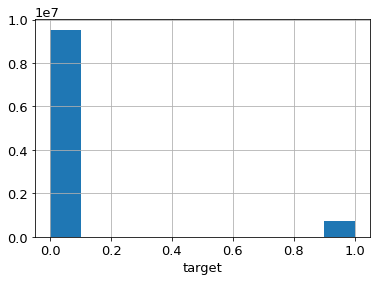

In [ ]:
plt.hist(train["target"])
plt.grid()
plt.xlabel("target")
plt.show()

# Check Maximum Score

In [ ]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

id2poi = get_id2poi(train)
poi2ids = get_poi2ids(train)

In [ ]:
def get_score(id2ids: dict):
    scores = []
    precisions = []
    recalls = []
    for id_str in train['id'].unique():
        if id_str in id2ids:
            preds = id2ids[id_str]
        else:
            preds = set()
        preds.add(id_str)
        targets = poi2ids[id2poi[id_str]]
        score = len((targets & preds)) / len((targets | preds))
        if len(preds) == 0:
            precision = 0
        else:
            precision = len((targets & preds)) / len(preds)
        recall = len((targets & preds)) / len(targets)
        scores.append(score)
        precisions.append(precision)
        recalls.append(recall)
    scores = np.array(scores)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    return scores.mean(), precisions.mean(), recalls.mean()

In [ ]:
id2ids = train[train[CFG.target] == train['near_target']].groupby('id')['near_id'].apply(lambda x: set(x))
score, precision, recall = get_score(id2ids)
print(score)

0.8904038900654864


In [ ]:
# del train
# gc.collect()

# Feature Engineering

In [ ]:
if "google.colab" in sys.modules:
    !pip install Levenshtein

     |████████████████████████████████| 258 kB 4.1 MB/s 
     |████████████████████████████████| 1.8 MB 73.8 MB/s 
     |████████████████████████████████| 103 kB 57.3 MB/s 


In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
import Levenshtein
import difflib

def _add_distance_features(args):
    _, df = args

    columns = ['name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']

    for c in columns:
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for str1, str2 in df[[c, f"near_{c}"]].values.astype(str):
            if str1==str1 and str2==str2:
                geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                levens.append(Levenshtein.distance(str1, str2))
                jaros.append(Levenshtein.jaro_winkler(str1, str2))
                lcss.append(LCS(str(str1), str(str2)))
            else:
                geshs.append(-1)
                levens.append(-1)
                jaros.append(-1)
        df[f"near_{c}_gesh"] = geshs
        df[f"near_{c}_leven"] = levens
        df[f"near_{c}_jaro"] = jaros
        df[f"near_{c}_lcs"] = lcss
        
        if not c in ['country', "phone", "zip"]:
            df[f"{c}_len"] = df[c].astype(str).map(len)
            df[f"near_{c}_len"] = df[f"near_{c}"].astype(str).map(len)
            df[f"near_{c}_nleven"] = df[f"near_{c}_leven"] / df[[f"near_{c}_len", f"{c}_len"]].max(axis=1)
            df[f"near_{c}_nlcsi"] = df[f"near_{c}_lcs"] / df[f"near_{c}_len"]
            df[f"near_{c}_nlcs0"] = df[f"near_{c}_lcs"] / df[f"{c}_len"]
    return df

def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

train_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "train_distance_features.csv"))
test_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "test_distance_features.csv"))

if CFG.save and (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train = pd.read_csv(train_distance_features_path)
    test = pd.read_csv(test_distance_features_path)
else:
    train = add_distance_features(train)
    test = add_distance_features(test)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
display(train.head(1))
display(test.head(1))

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_phone_lcs,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0
12,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,0,1.0,0,1.0,33,33,33,0.0,1.0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_phone_lcs,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0
2,E_001b6bad66eb98,"gelora sriwijaya, jaka baring sport city",-3.014675,104.794374,nan,nan,nan,nan,id,nan,...,3,0.695652,7,0.461111,8,8,15,0.466667,0.533333,1.0


In [ ]:
if CFG.save and not (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train.to_csv(train_distance_features_path, index=False)
    test.to_csv(test_distance_features_path, index=False)

# Delete Unusing Columns (just for avoiding OOM)

In [ ]:
features = []

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

features.append(f"d_near")
for c in columns:        
    features += [f"near_{c}_gesh", f"near_{c}_jaro", f"near_{c}_lcs"]
    if c in ['country', "phone", "zip"]:
        features += [f"near_{c}_leven"]
    else:
        features += [f"near_{c}_len", f"near_{c}_nleven", f"near_{c}_nlcsi", f"near_{c}_nlcs0"]

for f in features:
#     assert f in train.columns
    if f not in test.columns:
        test[f] = np.nan

print(features)

['d_near', 'near_name_gesh', 'near_name_jaro', 'near_name_lcs', 'near_name_len', 'near_name_nleven', 'near_name_nlcsi', 'near_name_nlcs0', 'near_address_gesh', 'near_address_jaro', 'near_address_lcs', 'near_address_len', 'near_address_nleven', 'near_address_nlcsi', 'near_address_nlcs0', 'near_city_gesh', 'near_city_jaro', 'near_city_lcs', 'near_city_len', 'near_city_nleven', 'near_city_nlcsi', 'near_city_nlcs0', 'near_state_gesh', 'near_state_jaro', 'near_state_lcs', 'near_state_len', 'near_state_nleven', 'near_state_nlcsi', 'near_state_nlcs0', 'near_zip_gesh', 'near_zip_jaro', 'near_zip_lcs', 'near_zip_leven', 'near_country_gesh', 'near_country_jaro', 'near_country_lcs', 'near_country_leven', 'near_url_gesh', 'near_url_jaro', 'near_url_lcs', 'near_url_len', 'near_url_nleven', 'near_url_nlcsi', 'near_url_nlcs0', 'near_phone_gesh', 'near_phone_jaro', 'near_phone_lcs', 'near_phone_leven', 'near_categories_gesh', 'near_categories_jaro', 'near_categories_lcs', 'near_categories_len', 'near_

In [ ]:
train = train[features + [CFG.target, "target", "id", "near_id"]]
test = test[features + ["id", "near_id"]]

train[features] = train[features].astype(np.float16)
test[features] = test[features].astype(np.float16)

train["target"] = train["target"].fillna(0)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

for _ in range(5):
    gc.collect()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10248613 entries, 0 to 10248612
Data columns (total 59 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   d_near                  float16
 1   near_name_gesh          float16
 2   near_name_jaro          float16
 3   near_name_lcs           float16
 4   near_name_len           float16
 5   near_name_nleven        float16
 6   near_name_nlcsi         float16
 7   near_name_nlcs0         float16
 8   near_address_gesh       float16
 9   near_address_jaro       float16
 10  near_address_lcs        float16
 11  near_address_len        float16
 12  near_address_nleven     float16
 13  near_address_nlcsi      float16
 14  near_address_nlcs0      float16
 15  near_city_gesh          float16
 16  near_city_jaro          float16
 17  near_city_lcs           float16
 18  near_city_len           float16
 19  near_city_nleven        float16
 20  near_city_nlcsi         float16
 21  near_city_nlcs0         float

# Split Folds

In [ ]:
kf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
for i, (trn_idx, val_idx) in tqdm(enumerate(kf.split(train, train["target"], train["target"]))):
    train.loc[val_idx, "fold"] = i

0it [00:00, ?it/s]

# Model Learning

In [ ]:
import lightgbm as lgbm

def fit_lgbm(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), 2), dtype=np.float64)
    
    for i in tqdm(range(CFG.n_splits)):
        print(f"== fold {i} ==")
        trn_idx = folds!=i
        val_idx = folds==i
        X_train, y_train = X[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        if model_dir is None:
            model = lgbm.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='binary',  
    #             verbose=-1)
                verbose=50)
        else:
            with open(f'{model_dir}/lgbm_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgbm(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}

if os.path.exists(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, 'lgbm_fold0.pkl'))):
    models = [joblib.load(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))) for i in range(CFG.n_splits)]
    oof = pd.read_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")))
    oof = oof.values
else:
    oof, models = fit_lgbm(train[features], train["target"].astype(int), 
                          params=params, n_class=2, 
                          N_SPLITS=CFG.n_splits, folds=train["fold"].values)
    pd.DataFrame(oof).to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")), index = False)
pred = inference_lgbm(models, test[features])

  0%|          | 0/3 [00:00<?, ?it/s]

== fold 0 ==
[50]	valid_0's binary_logloss: 0.0853885
[100]	valid_0's binary_logloss: 0.0820101
[150]	valid_0's binary_logloss: 0.0802736
[200]	valid_0's binary_logloss: 0.0794232
[250]	valid_0's binary_logloss: 0.0785932
[300]	valid_0's binary_logloss: 0.0780508
[350]	valid_0's binary_logloss: 0.0775866
[400]	valid_0's binary_logloss: 0.0771148
[450]	valid_0's binary_logloss: 0.0766765
[500]	valid_0's binary_logloss: 0.0763226
[550]	valid_0's binary_logloss: 0.0759882
[600]	valid_0's binary_logloss: 0.0756456
[650]	valid_0's binary_logloss: 0.0753559
[700]	valid_0's binary_logloss: 0.0751055
[750]	valid_0's binary_logloss: 0.074892
[800]	valid_0's binary_logloss: 0.0746688
[850]	valid_0's binary_logloss: 0.0744502
[900]	valid_0's binary_logloss: 0.0742583
[950]	valid_0's binary_logloss: 0.0740629
[1000]	valid_0's binary_logloss: 0.0738709
[1050]	valid_0's binary_logloss: 0.0737239
[1100]	valid_0's binary_logloss: 0.073549
[1150]	valid_0's binary_logloss: 0.0734131
[1200]	valid_0's bin

In [ ]:
train["pred"] = oof[:, -1]

# Check CV

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 81 kB 9.7 MB/s 
     |████████████████████████████████| 210 kB 55.5 MB/s 
     |████████████████████████████████| 78 kB 6.7 MB/s 
     |████████████████████████████████| 146 kB 56.2 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
     |████████████████████████████████| 112 kB 50.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=3248e87d37611ef498bd8691f6f04926a9162b5eea0bdf07796e7a6058804945
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2ids = train[train["pred"] > x].groupby('id')['near_id'].apply(lambda x: set(x))
    score, precision, recall = get_score(id2ids)
    print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-12 15:49:40,077] A new study created in memory with name: no-name-9cbd39d8-fa29-476e-a521-3c423e55c2d1
[I 2022-05-12 15:50:02,320] Trial 0 finished with value: 0.8243775583774008 and parameters: {'threshold': 0.3801717534931234}. Best is trial 0 with value: 0.8243775583774008.


CV: 0.824378, precision: 0.961800, recall: 0.856653


[I 2022-05-12 15:50:33,912] Trial 1 finished with value: 0.7275335546027362 and parameters: {'threshold': 0.03470296455435118}. Best is trial 0 with value: 0.8243775583774008.


CV: 0.727534, precision: 0.813570, recall: 0.882885


[I 2022-05-12 15:50:56,084] Trial 2 finished with value: 0.8230023667668522 and parameters: {'threshold': 0.34041981006772826}. Best is trial 0 with value: 0.8243775583774008.


CV: 0.823002, precision: 0.957035, recall: 0.859365


[I 2022-05-12 15:51:17,672] Trial 3 finished with value: 0.8224769969087901 and parameters: {'threshold': 0.32832548026751895}. Best is trial 0 with value: 0.8243775583774008.


CV: 0.822477, precision: 0.955449, recall: 0.860180


[I 2022-05-12 15:51:34,616] Trial 4 finished with value: 0.8095230884670314 and parameters: {'threshold': 0.7959343100585089}. Best is trial 0 with value: 0.8243775583774008.


CV: 0.809523, precision: 0.990689, recall: 0.817200


[I 2022-05-12 15:51:57,741] Trial 5 finished with value: 0.8184379753940011 and parameters: {'threshold': 0.26679814441195626}. Best is trial 0 with value: 0.8243775583774008.


CV: 0.818438, precision: 0.945773, recall: 0.864341


[I 2022-05-12 15:52:17,567] Trial 6 finished with value: 0.8236342258945575 and parameters: {'threshold': 0.5879378784328076}. Best is trial 0 with value: 0.8243775583774008.


CV: 0.823634, precision: 0.979458, recall: 0.840826


[I 2022-05-12 15:52:40,528] Trial 7 finished with value: 0.8124403101617944 and parameters: {'threshold': 0.21140150553075943}. Best is trial 0 with value: 0.8243775583774008.


CV: 0.812440, precision: 0.934277, recall: 0.868077


[I 2022-05-12 15:53:03,351] Trial 8 finished with value: 0.8168902772643429 and parameters: {'threshold': 0.24951015394743337}. Best is trial 0 with value: 0.8243775583774008.


CV: 0.816890, precision: 0.942559, recall: 0.865509


[I 2022-05-12 15:53:17,027] Trial 9 finished with value: 0.7571368176132494 and parameters: {'threshold': 0.9707788141510111}. Best is trial 0 with value: 0.8243775583774008.


CV: 0.757137, precision: 0.998438, recall: 0.758403


[I 2022-05-12 15:53:37,103] Trial 10 finished with value: 0.8243882976095247 and parameters: {'threshold': 0.5634247527463957}. Best is trial 10 with value: 0.8243882976095247.


CV: 0.824388, precision: 0.977824, recall: 0.842980


[I 2022-05-12 15:53:56,784] Trial 11 finished with value: 0.8239645119452179 and parameters: {'threshold': 0.5778332730602258}. Best is trial 10 with value: 0.8243882976095247.


CV: 0.823965, precision: 0.978820, recall: 0.841703


[I 2022-05-12 15:54:16,871] Trial 12 finished with value: 0.8252621829514983 and parameters: {'threshold': 0.5171790181189573}. Best is trial 12 with value: 0.8252621829514983.


CV: 0.825262, precision: 0.974472, recall: 0.846706


[I 2022-05-12 15:54:34,991] Trial 13 finished with value: 0.8200661142500676 and parameters: {'threshold': 0.6695729999920337}. Best is trial 12 with value: 0.8252621829514983.


CV: 0.820066, precision: 0.984382, recall: 0.833076


[I 2022-05-12 15:54:55,476] Trial 14 finished with value: 0.8255658858811822 and parameters: {'threshold': 0.45498865508408715}. Best is trial 14 with value: 0.8255658858811822.


CV: 0.825566, precision: 0.969296, recall: 0.851440


[I 2022-05-12 15:55:17,002] Trial 15 finished with value: 0.8254816496419347 and parameters: {'threshold': 0.43821646610669895}. Best is trial 14 with value: 0.8255658858811822.


CV: 0.825482, precision: 0.967792, recall: 0.852640


[I 2022-05-12 15:55:34,461] Trial 16 finished with value: 0.814521680159624 and parameters: {'threshold': 0.7466300009662357}. Best is trial 14 with value: 0.8255658858811822.


CV: 0.814522, precision: 0.988370, recall: 0.824163


[I 2022-05-12 15:55:55,317] Trial 17 finished with value: 0.8251913853909326 and parameters: {'threshold': 0.4164622438385099}. Best is trial 14 with value: 0.8255658858811822.


CV: 0.825191, precision: 0.965697, recall: 0.854142


[I 2022-05-12 15:56:15,840] Trial 18 finished with value: 0.8254558358503071 and parameters: {'threshold': 0.4348080239934581}. Best is trial 14 with value: 0.8255658858811822.


CV: 0.825456, precision: 0.967474, recall: 0.852880


[I 2022-05-12 15:56:40,579] Trial 19 finished with value: 0.799190181538934 and parameters: {'threshold': 0.1421412116863422}. Best is trial 14 with value: 0.8255658858811822.


CV: 0.799190, precision: 0.912604, recall: 0.873049


[I 2022-05-12 15:56:55,824] Trial 20 finished with value: 0.7824613340853749 and parameters: {'threshold': 0.9269479534741496}. Best is trial 14 with value: 0.8255658858811822.


CV: 0.782461, precision: 0.996427, recall: 0.785376


[I 2022-05-12 15:57:16,377] Trial 21 finished with value: 0.8256046628299001 and parameters: {'threshold': 0.46423732580102284}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.825605, precision: 0.970109, recall: 0.850788


[I 2022-05-12 15:57:36,919] Trial 22 finished with value: 0.825571750450155 and parameters: {'threshold': 0.4580176264016142}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.825572, precision: 0.969559, recall: 0.851226


[I 2022-05-12 15:57:55,951] Trial 23 finished with value: 0.8196145771504159 and parameters: {'threshold': 0.6776893676403125}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.819615, precision: 0.984840, recall: 0.832241


[I 2022-05-12 15:58:16,263] Trial 24 finished with value: 0.8254504970799963 and parameters: {'threshold': 0.49574498399930644}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.825450, precision: 0.972737, recall: 0.848383


[I 2022-05-12 15:58:35,399] Trial 25 finished with value: 0.8202589612060459 and parameters: {'threshold': 0.6662273293072281}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.820259, precision: 0.984199, recall: 0.833425


[I 2022-05-12 15:58:55,955] Trial 26 finished with value: 0.8255463981218292 and parameters: {'threshold': 0.485552666908689}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.825546, precision: 0.971916, recall: 0.849185


[I 2022-05-12 15:59:20,215] Trial 27 finished with value: 0.7987479463054465 and parameters: {'threshold': 0.14055344681736237}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.798748, precision: 0.911920, recall: 0.873170


[I 2022-05-12 15:59:41,956] Trial 28 finished with value: 0.821601362504837 and parameters: {'threshold': 0.3113591350316116}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.821601, precision: 0.953051, recall: 0.861343


[I 2022-05-12 16:00:03,487] Trial 29 finished with value: 0.8243999148674452 and parameters: {'threshold': 0.38134168829970755}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.824400, precision: 0.961929, recall: 0.856568


[I 2022-05-12 16:00:21,140] Trial 30 finished with value: 0.7998905395967614 and parameters: {'threshold': 0.8608149494937003}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.799891, precision: 0.993594, recall: 0.805144


[I 2022-05-12 16:00:41,734] Trial 31 finished with value: 0.8255666343693993 and parameters: {'threshold': 0.4827289399216819}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.825567, precision: 0.971683, recall: 0.849402


[I 2022-05-12 16:01:00,384] Trial 32 finished with value: 0.8226490696648657 and parameters: {'threshold': 0.6156995116464662}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.822649, precision: 0.981238, recall: 0.838333


[I 2022-05-12 16:01:20,574] Trial 33 finished with value: 0.825274888579262 and parameters: {'threshold': 0.5157080329570173}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.825275, precision: 0.974358, recall: 0.846817


[I 2022-05-12 16:01:41,519] Trial 34 finished with value: 0.8244751538313599 and parameters: {'threshold': 0.38415500012108733}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.824475, precision: 0.962249, recall: 0.856370


[I 2022-05-12 16:02:02,742] Trial 35 finished with value: 0.8256031022304829 and parameters: {'threshold': 0.4645669386777463}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.825603, precision: 0.970138, recall: 0.850760


[I 2022-05-12 16:02:24,548] Trial 36 finished with value: 0.8224595675241603 and parameters: {'threshold': 0.32782529273835176}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.822460, precision: 0.955382, recall: 0.860217


[I 2022-05-12 16:02:43,552] Trial 37 finished with value: 0.8247784167007722 and parameters: {'threshold': 0.5468279354539536}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.824778, precision: 0.976669, recall: 0.844349


[I 2022-05-12 16:03:02,640] Trial 38 finished with value: 0.822033170615782 and parameters: {'threshold': 0.6308917578133275}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.822033, precision: 0.982164, recall: 0.836928


[I 2022-05-12 16:03:20,810] Trial 39 finished with value: 0.8143400028384022 and parameters: {'threshold': 0.7486189077433796}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.814340, precision: 0.988465, recall: 0.823901


[I 2022-05-12 16:03:42,914] Trial 40 finished with value: 0.8192200327433189 and parameters: {'threshold': 0.27616380212160246}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.819220, precision: 0.947462, recall: 0.863693


[I 2022-05-12 16:04:03,511] Trial 41 finished with value: 0.8255752493438142 and parameters: {'threshold': 0.4536096839181335}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.825575, precision: 0.969187, recall: 0.851547


[I 2022-05-12 16:04:25,480] Trial 42 finished with value: 0.8242373027533411 and parameters: {'threshold': 0.3752487925176465}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.824237, precision: 0.961237, recall: 0.856995


[I 2022-05-12 16:04:44,778] Trial 43 finished with value: 0.8255666964817986 and parameters: {'threshold': 0.4834063188186079}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.825567, precision: 0.971738, recall: 0.849354


[I 2022-05-12 16:05:04,552] Trial 44 finished with value: 0.8249638002291099 and parameters: {'threshold': 0.5355099135511825}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.824964, precision: 0.975848, recall: 0.845237


[I 2022-05-12 16:05:26,580] Trial 45 finished with value: 0.8239867792826742 and parameters: {'threshold': 0.36617979959704905}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.823987, precision: 0.960217, recall: 0.857627


[I 2022-05-12 16:05:49,404] Trial 46 finished with value: 0.8125601563977843 and parameters: {'threshold': 0.21220736611442753}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.812560, precision: 0.934488, recall: 0.868019


[I 2022-05-12 16:06:10,201] Trial 47 finished with value: 0.8253004773257039 and parameters: {'threshold': 0.4224736779017499}. Best is trial 21 with value: 0.8256046628299001.


CV: 0.825300, precision: 0.966288, recall: 0.853740


[I 2022-05-12 16:06:29,683] Trial 48 finished with value: 0.8256090534931775 and parameters: {'threshold': 0.4714204249028396}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825609, precision: 0.970731, recall: 0.850254


[I 2022-05-12 16:06:50,686] Trial 49 finished with value: 0.8227995523673834 and parameters: {'threshold': 0.6121354720175182}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.822800, precision: 0.981006, recall: 0.838681


[I 2022-05-12 16:07:10,649] Trial 50 finished with value: 0.8242287663156135 and parameters: {'threshold': 0.5688940980363906}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.824229, precision: 0.978190, recall: 0.842509


[I 2022-05-12 16:07:31,904] Trial 51 finished with value: 0.8256044912623877 and parameters: {'threshold': 0.4627329426257911}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825604, precision: 0.969980, recall: 0.850898


[I 2022-05-12 16:07:51,881] Trial 52 finished with value: 0.8251190372392715 and parameters: {'threshold': 0.4136927845533752}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825119, precision: 0.965399, recall: 0.854323


[I 2022-05-12 16:08:13,370] Trial 53 finished with value: 0.8255742101602963 and parameters: {'threshold': 0.45739711292008833}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825574, precision: 0.969506, recall: 0.851273


[I 2022-05-12 16:08:33,770] Trial 54 finished with value: 0.8230111544049069 and parameters: {'threshold': 0.34073223725905954}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.823011, precision: 0.957076, recall: 0.859340


[I 2022-05-12 16:08:55,242] Trial 55 finished with value: 0.8256025300901791 and parameters: {'threshold': 0.46504592337138173}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825603, precision: 0.970181, recall: 0.850723


[I 2022-05-12 16:09:17,176] Trial 56 finished with value: 0.8204330891430819 and parameters: {'threshold': 0.29318118920395564}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.820433, precision: 0.950269, recall: 0.862541


[I 2022-05-12 16:09:36,254] Trial 57 finished with value: 0.8249145860671702 and parameters: {'threshold': 0.5381811677808376}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.824915, precision: 0.976051, recall: 0.845017


[I 2022-05-12 16:09:56,908] Trial 58 finished with value: 0.8250368748757839 and parameters: {'threshold': 0.4105510897224013}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825037, precision: 0.965058, recall: 0.854531


[I 2022-05-12 16:10:16,373] Trial 59 finished with value: 0.8234897244094859 and parameters: {'threshold': 0.5930433600116232}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.823490, precision: 0.979799, recall: 0.840389


[I 2022-05-12 16:10:36,574] Trial 60 finished with value: 0.8253186938277577 and parameters: {'threshold': 0.51211789084516}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825319, precision: 0.974075, recall: 0.847104


[I 2022-05-12 16:10:58,170] Trial 61 finished with value: 0.8255970079709172 and parameters: {'threshold': 0.4608264537539694}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825597, precision: 0.969818, recall: 0.851032


[I 2022-05-12 16:11:17,784] Trial 62 finished with value: 0.8255968715083135 and parameters: {'threshold': 0.4607519308682201}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825597, precision: 0.969810, recall: 0.851038


[I 2022-05-12 16:11:38,985] Trial 63 finished with value: 0.8256020850790681 and parameters: {'threshold': 0.4677455716294575}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825602, precision: 0.970416, recall: 0.850519


[I 2022-05-12 16:12:00,157] Trial 64 finished with value: 0.8238932612661457 and parameters: {'threshold': 0.3628835675503056}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.823893, precision: 0.959833, recall: 0.857854


[I 2022-05-12 16:12:20,164] Trial 65 finished with value: 0.8250298970373329 and parameters: {'threshold': 0.41007372968029804}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825030, precision: 0.965010, recall: 0.854567


[I 2022-05-12 16:12:40,185] Trial 66 finished with value: 0.8254254379930864 and parameters: {'threshold': 0.5003021625836415}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825425, precision: 0.973096, recall: 0.848042


[I 2022-05-12 16:13:00,849] Trial 67 finished with value: 0.8245818139048646 and parameters: {'threshold': 0.5550415859568416}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.824582, precision: 0.977244, recall: 0.843663


[I 2022-05-12 16:13:19,062] Trial 68 finished with value: 0.8216310100010822 and parameters: {'threshold': 0.639531268165024}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.821631, precision: 0.982668, recall: 0.836097


[I 2022-05-12 16:13:39,391] Trial 69 finished with value: 0.8255902581124078 and parameters: {'threshold': 0.4769270828627654}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825590, precision: 0.971212, recall: 0.849830


[I 2022-05-12 16:14:00,818] Trial 70 finished with value: 0.8228280520965434 and parameters: {'threshold': 0.3359964416329537}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.822828, precision: 0.956470, recall: 0.859668


[I 2022-05-12 16:14:22,354] Trial 71 finished with value: 0.8255134590945946 and parameters: {'threshold': 0.4448335727314575}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825513, precision: 0.968398, recall: 0.852154


[I 2022-05-12 16:14:41,513] Trial 72 finished with value: 0.8250866181702727 and parameters: {'threshold': 0.5288974023842168}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825087, precision: 0.975370, recall: 0.845769


[I 2022-05-12 16:15:03,361] Trial 73 finished with value: 0.824877273074675 and parameters: {'threshold': 0.40204383211650563}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.824877, precision: 0.964196, recall: 0.855120


[I 2022-05-12 16:15:31,334] Trial 74 finished with value: 0.7058692439066984 and parameters: {'threshold': 0.024965841555049217}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.705869, precision: 0.785542, recall: 0.884214


[I 2022-05-12 16:15:51,743] Trial 75 finished with value: 0.8256068022920697 and parameters: {'threshold': 0.46840719626131727}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825607, precision: 0.970476, recall: 0.850475


[I 2022-05-12 16:16:11,709] Trial 76 finished with value: 0.823824451770589 and parameters: {'threshold': 0.5819630423496781}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.823824, precision: 0.979085, recall: 0.841339


[I 2022-05-12 16:16:32,267] Trial 77 finished with value: 0.8254223292411872 and parameters: {'threshold': 0.5014070545524956}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825422, precision: 0.973192, recall: 0.847957


[I 2022-05-12 16:16:52,174] Trial 78 finished with value: 0.82545157328266 and parameters: {'threshold': 0.43462866308553216}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825452, precision: 0.967453, recall: 0.852895


[I 2022-05-12 16:17:12,577] Trial 79 finished with value: 0.8255583351481333 and parameters: {'threshold': 0.4813554535420248}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825558, precision: 0.971569, recall: 0.849493


[I 2022-05-12 16:17:34,660] Trial 80 finished with value: 0.8236104947090479 and parameters: {'threshold': 0.3545765885749045}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.823610, precision: 0.958820, recall: 0.858444


[I 2022-05-12 16:17:55,238] Trial 81 finished with value: 0.8256067255026796 and parameters: {'threshold': 0.46486046381369506}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825607, precision: 0.970166, recall: 0.850740


[I 2022-05-12 16:18:14,818] Trial 82 finished with value: 0.8256032322471567 and parameters: {'threshold': 0.4662577825491938}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825603, precision: 0.970283, recall: 0.850633


[I 2022-05-12 16:18:36,818] Trial 83 finished with value: 0.8245596102026694 and parameters: {'threshold': 0.3873954817163765}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.824560, precision: 0.962602, recall: 0.856153


[I 2022-05-12 16:18:56,109] Trial 84 finished with value: 0.8252284636853479 and parameters: {'threshold': 0.5199372492773773}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825228, precision: 0.974685, recall: 0.846493


[I 2022-05-12 16:19:16,797] Trial 85 finished with value: 0.8254552662336413 and parameters: {'threshold': 0.4352283259458494}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825455, precision: 0.967513, recall: 0.852849


[I 2022-05-12 16:19:37,156] Trial 86 finished with value: 0.8256041377676581 and parameters: {'threshold': 0.4720794999079563}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825604, precision: 0.970789, recall: 0.850201


[I 2022-05-12 16:19:56,843] Trial 87 finished with value: 0.8243255250543315 and parameters: {'threshold': 0.5654366703555626}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.824326, precision: 0.977956, recall: 0.842803


[I 2022-05-12 16:20:18,802] Trial 88 finished with value: 0.8247018392933452 and parameters: {'threshold': 0.3925800187070836}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.824702, precision: 0.963174, recall: 0.855796


[I 2022-05-12 16:20:38,154] Trial 89 finished with value: 0.8254027041590413 and parameters: {'threshold': 0.5023658662392513}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825403, precision: 0.973270, recall: 0.847872


[I 2022-05-12 16:20:59,745] Trial 90 finished with value: 0.8253747523865554 and parameters: {'threshold': 0.427498184229509}. Best is trial 48 with value: 0.8256090534931775.


CV: 0.825375, precision: 0.966777, recall: 0.853397


[I 2022-05-12 16:21:19,401] Trial 91 finished with value: 0.8256091333221647 and parameters: {'threshold': 0.471410297497117}. Best is trial 91 with value: 0.8256091333221647.


CV: 0.825609, precision: 0.970730, recall: 0.850255


[I 2022-05-12 16:21:39,973] Trial 92 finished with value: 0.8249040622376399 and parameters: {'threshold': 0.5388898240014487}. Best is trial 91 with value: 0.8256091333221647.


CV: 0.824904, precision: 0.976104, recall: 0.844959


[I 2022-05-12 16:21:59,454] Trial 93 finished with value: 0.8255649965869165 and parameters: {'threshold': 0.48062226494338467}. Best is trial 91 with value: 0.8256091333221647.


CV: 0.825565, precision: 0.971512, recall: 0.849549


[I 2022-05-12 16:22:22,371] Trial 94 finished with value: 0.8253359892182114 and parameters: {'threshold': 0.5106987766812471}. Best is trial 91 with value: 0.8256091333221647.


CV: 0.825336, precision: 0.973949, recall: 0.847227


[I 2022-05-12 16:22:44,580] Trial 95 finished with value: 0.8255091821541028 and parameters: {'threshold': 0.4418881985315867}. Best is trial 91 with value: 0.8256091333221647.


CV: 0.825509, precision: 0.968136, recall: 0.852374


[I 2022-05-12 16:23:04,701] Trial 96 finished with value: 0.8246368089455708 and parameters: {'threshold': 0.5528451293691635}. Best is trial 91 with value: 0.8256091333221647.


CV: 0.824637, precision: 0.977080, recall: 0.843855


[I 2022-05-12 16:23:27,066] Trial 97 finished with value: 0.8214091430403866 and parameters: {'threshold': 0.3083044954407571}. Best is trial 91 with value: 0.8256091333221647.


CV: 0.821409, precision: 0.952597, recall: 0.861541


[I 2022-05-12 16:23:46,468] Trial 98 finished with value: 0.8256020074247264 and parameters: {'threshold': 0.4671130373509121}. Best is trial 91 with value: 0.8256091333221647.


CV: 0.825602, precision: 0.970362, recall: 0.850565


[I 2022-05-12 16:24:05,587] Trial 99 finished with value: 0.8230073444287673 and parameters: {'threshold': 0.6063816622196104}. Best is trial 91 with value: 0.8256091333221647.


CV: 0.823007, precision: 0.980628, recall: 0.839205


In [ ]:
threshold = study.best_params['threshold']
threshold

0.471410297497117

In [ ]:
study.best_value

0.8256091333221647

In [ ]:
id2ids = train[train["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
score, precision, recall = get_score(id2ids)
print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")

CV: 0.825609, precision: 0.970730, recall: 0.850255


# Check Feature Importances

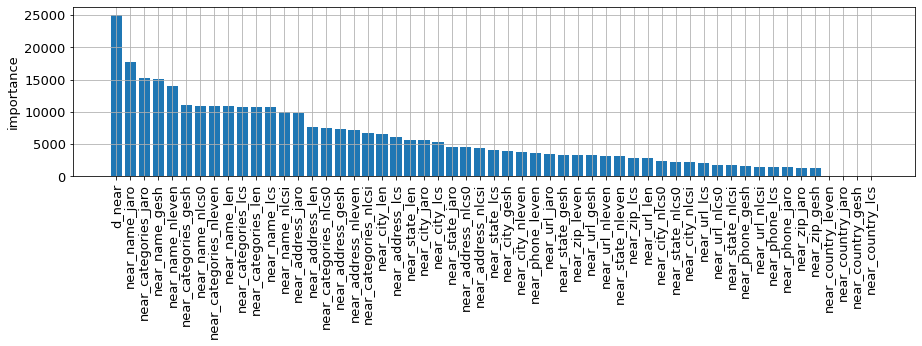

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

# Simple Post-Processing

In [40]:
import optuna
from copy import deepcopy

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2ids = train[train["pred"] > x].groupby('id')['near_id'].apply(lambda x: set(x))
    train["matches"] = train["id"]
    if len(id2ids) > 0:
        train.loc[train["id"].isin(id2ids.keys()), "matches"] += " " + train.loc[train["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
    id2match = dict(zip(train["id"].values, train["matches"].str.split()))

    for match in tqdm(train["matches"]):
        match = match.split()
        if len(match) == 1:
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    id2ids = deepcopy(id2match)
    for id, ids in id2ids.items():
        id2ids[id] = set(ids)
    score, precision, recall = get_score(id2ids)
    print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-12 17:18:01,207] A new study created in memory with name: no-name-23cad12d-8ab0-4979-9ee8-6d261f9a2f82


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:19:07,780] Trial 0 finished with value: 0.8314538875155467 and parameters: {'threshold': 0.566632566118691}. Best is trial 0 with value: 0.8314538875155467.


CV: 0.831454, precision: 0.970907, recall: 0.856111


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:20:12,162] Trial 1 finished with value: 0.8298659175526082 and parameters: {'threshold': 0.655214143152245}. Best is trial 0 with value: 0.8314538875155467.


CV: 0.829866, precision: 0.978002, recall: 0.848409


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:21:19,242] Trial 2 finished with value: 0.8249934147420981 and parameters: {'threshold': 0.7516190799508852}. Best is trial 0 with value: 0.8314538875155467.


CV: 0.824993, precision: 0.984567, recall: 0.837902


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.793675, precision: 0.894995, recall: 0.883422


[I 2022-05-12 17:22:37,037] Trial 3 finished with value: 0.793674813541497 and parameters: {'threshold': 0.14973876200045766}. Best is trial 0 with value: 0.8314538875155467.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:23:37,745] Trial 4 finished with value: 0.81062008914404 and parameters: {'threshold': 0.8734153301876395}. Best is trial 0 with value: 0.8314538875155467.


CV: 0.810620, precision: 0.991848, recall: 0.817343


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.830728, precision: 0.975598, recall: 0.851346


[I 2022-05-12 17:24:43,750] Trial 5 finished with value: 0.8307278938875977 and parameters: {'threshold': 0.6233299899242919}. Best is trial 0 with value: 0.8314538875155467.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.813545, precision: 0.925066, recall: 0.877673


[I 2022-05-12 17:25:58,043] Trial 6 finished with value: 0.8135454434409766 and parameters: {'threshold': 0.2407409296268893}. Best is trial 0 with value: 0.8314538875155467.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:27:01,503] Trial 7 finished with value: 0.8282494775748345 and parameters: {'threshold': 0.6965960156005852}. Best is trial 0 with value: 0.8314538875155467.


CV: 0.828249, precision: 0.980965, recall: 0.844251


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:28:18,286] Trial 8 finished with value: 0.8246752263829674 and parameters: {'threshold': 0.7561887786925373}. Best is trial 0 with value: 0.8314538875155467.


CV: 0.824675, precision: 0.984863, recall: 0.837323


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:29:33,036] Trial 9 finished with value: 0.8170780463771055 and parameters: {'threshold': 0.2669208581772602}. Best is trial 0 with value: 0.8314538875155467.


CV: 0.817078, precision: 0.931090, recall: 0.876045


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.829027, precision: 0.955996, recall: 0.866532


[I 2022-05-12 17:30:43,412] Trial 10 finished with value: 0.8290273826871044 and parameters: {'threshold': 0.4206544131977004}. Best is trial 0 with value: 0.8314538875155467.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.829807, precision: 0.958470, recall: 0.865175


[I 2022-05-12 17:31:53,417] Trial 11 finished with value: 0.8298071185132582 and parameters: {'threshold': 0.4417568650493213}. Best is trial 0 with value: 0.8314538875155467.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.831530, precision: 0.969657, recall: 0.857263


[I 2022-05-12 17:32:58,265] Trial 12 finished with value: 0.8315299946103764 and parameters: {'threshold': 0.552506736968835}. Best is trial 12 with value: 0.8315299946103764.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:33:48,197] Trial 13 finished with value: 0.7297003681286588 and parameters: {'threshold': 0.9939405255691611}. Best is trial 12 with value: 0.8315299946103764.


CV: 0.729700, precision: 0.999378, recall: 0.730200


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:35:42,964] Trial 14 finished with value: 0.5596227620724601 and parameters: {'threshold': 0.0065866819114479}. Best is trial 12 with value: 0.8315299946103764.


CV: 0.559623, precision: 0.603702, recall: 0.896907


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.831460, precision: 0.967044, recall: 0.859453


[I 2022-05-12 17:36:51,431] Trial 15 finished with value: 0.8314596231638014 and parameters: {'threshold': 0.5240084361517185}. Best is trial 12 with value: 0.8315299946103764.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:38:04,211] Trial 16 finished with value: 0.8304010024380428 and parameters: {'threshold': 0.46232683999797564}. Best is trial 12 with value: 0.8315299946103764.


CV: 0.830401, precision: 0.960718, recall: 0.863851


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:39:23,572] Trial 17 finished with value: 0.8280188709731358 and parameters: {'threshold': 0.39947714097369286}. Best is trial 12 with value: 0.8315299946103764.


CV: 0.828019, precision: 0.953288, recall: 0.867865


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.831512, precision: 0.969025, recall: 0.857790


[I 2022-05-12 17:40:28,117] Trial 18 finished with value: 0.8315116072793395 and parameters: {'threshold': 0.54544855981968}. Best is trial 12 with value: 0.8315299946103764.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.819180, precision: 0.934808, recall: 0.874956


[I 2022-05-12 17:41:41,145] Trial 19 finished with value: 0.8191797967193967 and parameters: {'threshold': 0.28449758658077023}. Best is trial 12 with value: 0.8315299946103764.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:42:42,658] Trial 20 finished with value: 0.8077459794830124 and parameters: {'threshold': 0.8872481926727043}. Best is trial 12 with value: 0.8315299946103764.


CV: 0.807746, precision: 0.992667, recall: 0.813779


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.831260, precision: 0.972942, recall: 0.854161


[I 2022-05-12 17:43:45,800] Trial 21 finished with value: 0.8312599462847883 and parameters: {'threshold': 0.5904434521136981}. Best is trial 12 with value: 0.8315299946103764.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:44:55,236] Trial 22 finished with value: 0.8312069756432471 and parameters: {'threshold': 0.5053719096985905}. Best is trial 12 with value: 0.8315299946103764.


CV: 0.831207, precision: 0.965168, recall: 0.860812


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:46:00,926] Trial 23 finished with value: 0.8315326823266469 and parameters: {'threshold': 0.5506546628362148}. Best is trial 23 with value: 0.8315326823266469.


CV: 0.831533, precision: 0.969500, recall: 0.857403


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:47:12,501] Trial 24 finished with value: 0.8232897206252715 and parameters: {'threshold': 0.3266773219707503}. Best is trial 23 with value: 0.8315326823266469.


CV: 0.823290, precision: 0.942569, recall: 0.872405


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:48:15,816] Trial 25 finished with value: 0.8262294230271808 and parameters: {'threshold': 0.7331014701778725}. Best is trial 23 with value: 0.8315326823266469.


CV: 0.826229, precision: 0.983388, recall: 0.840149


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:49:40,412] Trial 26 finished with value: 0.8268199935833305 and parameters: {'threshold': 0.376726054081503}. Best is trial 23 with value: 0.8315326823266469.


CV: 0.826820, precision: 0.950216, recall: 0.869319


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:50:48,677] Trial 27 finished with value: 0.8314608334427602 and parameters: {'threshold': 0.5276639824519818}. Best is trial 23 with value: 0.8315326823266469.


CV: 0.831461, precision: 0.967401, recall: 0.859148


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:51:52,415] Trial 28 finished with value: 0.8189224304030536 and parameters: {'threshold': 0.8167528625046558}. Best is trial 23 with value: 0.8315326823266469.


CV: 0.818922, precision: 0.988574, recall: 0.828394


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.831525, precision: 0.969668, recall: 0.857249


[I 2022-05-12 17:52:58,445] Trial 29 finished with value: 0.8315254868822857 and parameters: {'threshold': 0.5526513851897117}. Best is trial 23 with value: 0.8315326823266469.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:54:02,748] Trial 30 finished with value: 0.8304048406050637 and parameters: {'threshold': 0.636799627847193}. Best is trial 23 with value: 0.8315326823266469.


CV: 0.830405, precision: 0.976606, recall: 0.850142


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:55:06,781] Trial 31 finished with value: 0.8314743138228887 and parameters: {'threshold': 0.5656656972223558}. Best is trial 23 with value: 0.8315326823266469.


CV: 0.831474, precision: 0.970827, recall: 0.856197


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:56:11,562] Trial 32 finished with value: 0.8313372237852589 and parameters: {'threshold': 0.581918848807058}. Best is trial 23 with value: 0.8315326823266469.


CV: 0.831337, precision: 0.972250, recall: 0.854833


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:57:17,614] Trial 33 finished with value: 0.8285324709983106 and parameters: {'threshold': 0.6907905464304676}. Best is trial 23 with value: 0.8315326823266469.


CV: 0.828532, precision: 0.980560, recall: 0.844879


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:58:24,357] Trial 34 finished with value: 0.8308061782371388 and parameters: {'threshold': 0.4786951160926282}. Best is trial 23 with value: 0.8315326823266469.


CV: 0.830806, precision: 0.962495, recall: 0.862715


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 17:59:33,305] Trial 35 finished with value: 0.8299772176914808 and parameters: {'threshold': 0.6514341919803358}. Best is trial 23 with value: 0.8315326823266469.


CV: 0.829977, precision: 0.977710, recall: 0.848765


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:00:42,923] Trial 36 finished with value: 0.8315135155707049 and parameters: {'threshold': 0.5546036238774913}. Best is trial 23 with value: 0.8315326823266469.


CV: 0.831514, precision: 0.969853, recall: 0.857082


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:01:53,537] Trial 37 finished with value: 0.8259123290545817 and parameters: {'threshold': 0.3622951557164203}. Best is trial 23 with value: 0.8315326823266469.


CV: 0.825912, precision: 0.948156, recall: 0.870198


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.830835, precision: 0.975096, recall: 0.851886


[I 2022-05-12 18:02:59,179] Trial 38 finished with value: 0.8308353639347724 and parameters: {'threshold': 0.6170488009820789}. Best is trial 23 with value: 0.8315326823266469.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.821311, precision: 0.987265, recall: 0.831911


[I 2022-05-12 18:04:00,411] Trial 39 finished with value: 0.8213111803270667 and parameters: {'threshold': 0.7949968319870094}. Best is trial 23 with value: 0.8315326823266469.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:05:05,432] Trial 40 finished with value: 0.8287978799200192 and parameters: {'threshold': 0.6842711203514606}. Best is trial 23 with value: 0.8315326823266469.


CV: 0.828798, precision: 0.980096, recall: 0.845545


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:06:11,713] Trial 41 finished with value: 0.8314942405618825 and parameters: {'threshold': 0.5424656421172708}. Best is trial 23 with value: 0.8315326823266469.


CV: 0.831494, precision: 0.968748, recall: 0.858008


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:07:19,887] Trial 42 finished with value: 0.8308671664281488 and parameters: {'threshold': 0.4809201544479471}. Best is trial 23 with value: 0.8315326823266469.


CV: 0.830867, precision: 0.962723, recall: 0.862581


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:08:24,955] Trial 43 finished with value: 0.8313385218320986 and parameters: {'threshold': 0.5811316493206711}. Best is trial 23 with value: 0.8315326823266469.


CV: 0.831339, precision: 0.972173, recall: 0.854899


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:09:31,798] Trial 44 finished with value: 0.8294300992917475 and parameters: {'threshold': 0.43200759371030634}. Best is trial 23 with value: 0.8315326823266469.


CV: 0.829430, precision: 0.957316, recall: 0.865790


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:10:49,791] Trial 45 finished with value: 0.8000923121020569 and parameters: {'threshold': 0.1721973806445945}. Best is trial 23 with value: 0.8315326823266469.


CV: 0.800092, precision: 0.904273, recall: 0.881970


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:11:54,880] Trial 46 finished with value: 0.8308231238021296 and parameters: {'threshold': 0.6183730614768208}. Best is trial 23 with value: 0.8315326823266469.


CV: 0.830823, precision: 0.975200, recall: 0.851782


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:12:59,703] Trial 47 finished with value: 0.8314812270131366 and parameters: {'threshold': 0.5374213716388094}. Best is trial 23 with value: 0.8315326823266469.


CV: 0.831481, precision: 0.968288, recall: 0.858397


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.831004, precision: 0.963835, recall: 0.861766


[I 2022-05-12 18:14:07,666] Trial 48 finished with value: 0.8310041238381968 and parameters: {'threshold': 0.49209934303718655}. Best is trial 23 with value: 0.8315326823266469.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:15:09,936] Trial 49 finished with value: 0.8268247481033779 and parameters: {'threshold': 0.7237979085596821}. Best is trial 23 with value: 0.8315326823266469.


CV: 0.826825, precision: 0.982819, recall: 0.841237


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:16:14,328] Trial 50 finished with value: 0.829454419411554 and parameters: {'threshold': 0.6671682500437461}. Best is trial 23 with value: 0.8315326823266469.


CV: 0.829454, precision: 0.978844, recall: 0.847273


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:17:22,106] Trial 51 finished with value: 0.8315430885280596 and parameters: {'threshold': 0.5502049451928233}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.831543, precision: 0.969465, recall: 0.857442


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:18:28,391] Trial 52 finished with value: 0.830084308539796 and parameters: {'threshold': 0.45028745551421784}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.830084, precision: 0.959447, recall: 0.864619


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:19:34,297] Trial 53 finished with value: 0.8315316367110026 and parameters: {'threshold': 0.5517254703019459}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.831532, precision: 0.969590, recall: 0.857323


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:20:40,939] Trial 54 finished with value: 0.8308008198640741 and parameters: {'threshold': 0.6194742250709993}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.830801, precision: 0.975286, recall: 0.851688


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:21:46,481] Trial 55 finished with value: 0.8312911545916246 and parameters: {'threshold': 0.5846376483568441}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.831291, precision: 0.972453, recall: 0.854612


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:22:56,695] Trial 56 finished with value: 0.8282532984018443 and parameters: {'threshold': 0.40495410199406934}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.828253, precision: 0.953978, recall: 0.867507


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:24:03,060] Trial 57 finished with value: 0.831343120136866 and parameters: {'threshold': 0.5133884486071889}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.831343, precision: 0.965998, recall: 0.860235


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:25:13,245] Trial 58 finished with value: 0.8240167488364818 and parameters: {'threshold': 0.3356481688763677}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.824017, precision: 0.944058, recall: 0.871857


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:26:57,487] Trial 59 finished with value: 0.603209298279965 and parameters: {'threshold': 0.010356265420958577}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.603209, precision: 0.654445, recall: 0.896122


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:28:03,511] Trial 60 finished with value: 0.8315145253725077 and parameters: {'threshold': 0.5542941334554345}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.831515, precision: 0.969828, recall: 0.857106


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:29:08,286] Trial 61 finished with value: 0.8314922077574846 and parameters: {'threshold': 0.5560259467496805}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.831492, precision: 0.969977, recall: 0.856957


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.831204, precision: 0.965144, recall: 0.860830


[I 2022-05-12 18:30:13,724] Trial 62 finished with value: 0.8312038607783874 and parameters: {'threshold': 0.5051349745198999}. Best is trial 51 with value: 0.8315430885280596.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:31:20,582] Trial 63 finished with value: 0.8301937284718635 and parameters: {'threshold': 0.45455550612963036}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.830194, precision: 0.959876, recall: 0.864365


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:32:24,126] Trial 64 finished with value: 0.8309825448536875 and parameters: {'threshold': 0.6077901701937855}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.830983, precision: 0.974315, recall: 0.852705


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:33:26,040] Trial 65 finished with value: 0.8298650890198589 and parameters: {'threshold': 0.6553508508658592}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.829865, precision: 0.978014, recall: 0.848398


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.831534, precision: 0.969445, recall: 0.857448


[I 2022-05-12 18:34:33,695] Trial 66 finished with value: 0.8315335907473694 and parameters: {'threshold': 0.5500100264972501}. Best is trial 51 with value: 0.8315430885280596.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:35:39,591] Trial 67 finished with value: 0.8313062276751034 and parameters: {'threshold': 0.5102258739250605}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.831306, precision: 0.965669, recall: 0.860478


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.829186, precision: 0.956480, recall: 0.866266


[I 2022-05-12 18:36:48,287] Trial 68 finished with value: 0.8291858025992075 and parameters: {'threshold': 0.4245843191577336}. Best is trial 51 with value: 0.8315430885280596.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.830597, precision: 0.961501, recall: 0.863367


[I 2022-05-12 18:37:55,659] Trial 69 finished with value: 0.8305965900509164 and parameters: {'threshold': 0.4694341061634176}. Best is trial 51 with value: 0.8315430885280596.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:39:00,944] Trial 70 finished with value: 0.8313607354211858 and parameters: {'threshold': 0.5796965250370861}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.831361, precision: 0.972058, recall: 0.855017


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.831527, precision: 0.969639, recall: 0.857275


[I 2022-05-12 18:40:05,425] Trial 71 finished with value: 0.8315265791066322 and parameters: {'threshold': 0.5522894977153798}. Best is trial 51 with value: 0.8315430885280596.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:41:10,148] Trial 72 finished with value: 0.8315316096059249 and parameters: {'threshold': 0.5492090823161169}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.831532, precision: 0.969373, recall: 0.857510


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:42:15,688] Trial 73 finished with value: 0.8314683173184656 and parameters: {'threshold': 0.5263717079381071}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.831468, precision: 0.967291, recall: 0.859253


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:43:16,611] Trial 74 finished with value: 0.8274076647468975 and parameters: {'threshold': 0.7132611510847453}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.827408, precision: 0.982107, recall: 0.842434


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:44:21,546] Trial 75 finished with value: 0.8311157247774094 and parameters: {'threshold': 0.6016073642284515}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.831116, precision: 0.973831, recall: 0.853258


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:45:24,019] Trial 76 finished with value: 0.830351332775037 and parameters: {'threshold': 0.6403818780042895}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.830351, precision: 0.976910, recall: 0.849823


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:46:30,648] Trial 77 finished with value: 0.8309722532403081 and parameters: {'threshold': 0.4883757326688728}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.830972, precision: 0.963485, recall: 0.862038


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.824115, precision: 0.985252, recall: 0.836431


[I 2022-05-12 18:47:31,281] Trial 78 finished with value: 0.8241152050484603 and parameters: {'threshold': 0.7626889950393215}. Best is trial 51 with value: 0.8315430885280596.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:48:34,966] Trial 79 finished with value: 0.8293395686849425 and parameters: {'threshold': 0.670561547222029}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.829340, precision: 0.979098, recall: 0.846942


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:49:23,335] Trial 80 finished with value: 0.726772861697585 and parameters: {'threshold': 0.9946228622269475}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.726773, precision: 0.999438, recall: 0.727223


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:50:29,934] Trial 81 finished with value: 0.8314413502913123 and parameters: {'threshold': 0.5669276351627733}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.831441, precision: 0.970926, recall: 0.856083


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:51:34,452] Trial 82 finished with value: 0.8315302109161569 and parameters: {'threshold': 0.5511892949957389}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.831530, precision: 0.969544, recall: 0.857364


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.831491, precision: 0.968451, recall: 0.858267


[I 2022-05-12 18:52:38,676] Trial 83 finished with value: 0.8314910842128704 and parameters: {'threshold': 0.5392552341354069}. Best is trial 51 with value: 0.8315430885280596.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.831187, precision: 0.973524, recall: 0.853586


[I 2022-05-12 18:53:43,018] Trial 84 finished with value: 0.831187385450976 and parameters: {'threshold': 0.5976753344774504}. Best is trial 51 with value: 0.8315430885280596.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:54:48,850] Trial 85 finished with value: 0.8314580953068123 and parameters: {'threshold': 0.5287323671416507}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.831458, precision: 0.967500, recall: 0.859061


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:55:53,040] Trial 86 finished with value: 0.8305604503140339 and parameters: {'threshold': 0.6312248434454734}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.830560, precision: 0.976206, recall: 0.850651


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:56:58,647] Trial 87 finished with value: 0.8307120729860865 and parameters: {'threshold': 0.4747453001998823}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.830712, precision: 0.962065, recall: 0.862992


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.831415, precision: 0.971254, recall: 0.855773


[I 2022-05-12 18:58:04,485] Trial 88 finished with value: 0.8314148243713231 and parameters: {'threshold': 0.5706261206255088}. Best is trial 51 with value: 0.8315430885280596.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 18:59:10,857] Trial 89 finished with value: 0.8310476580548412 and parameters: {'threshold': 0.4954161019287655}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.831048, precision: 0.964168, recall: 0.861522


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 19:00:20,986] Trial 90 finished with value: 0.8271732891713384 and parameters: {'threshold': 0.3830087550553106}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.827173, precision: 0.951083, recall: 0.868917


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 19:01:26,069] Trial 91 finished with value: 0.8315152449209665 and parameters: {'threshold': 0.55426948203655}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.831515, precision: 0.969826, recall: 0.857108


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 19:02:31,563] Trial 92 finished with value: 0.8315361905579151 and parameters: {'threshold': 0.5494714145138369}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.831536, precision: 0.969394, recall: 0.857495


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 19:03:35,870] Trial 93 finished with value: 0.8311683328346623 and parameters: {'threshold': 0.599605200158721}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.831168, precision: 0.973681, recall: 0.853438


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.831333, precision: 0.965977, recall: 0.860244


[I 2022-05-12 19:04:41,342] Trial 94 finished with value: 0.8313331189040983 and parameters: {'threshold': 0.5132123356710884}. Best is trial 51 with value: 0.8315430885280596.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.829964, precision: 0.959059, recall: 0.864833


[I 2022-05-12 19:05:50,605] Trial 95 finished with value: 0.8299635166224386 and parameters: {'threshold': 0.44690267566054587}. Best is trial 51 with value: 0.8315430885280596.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.831385, precision: 0.971588, recall: 0.855452


[I 2022-05-12 19:06:54,529] Trial 96 finished with value: 0.8313854337000128 and parameters: {'threshold': 0.5743397332655193}. Best is trial 51 with value: 0.8315430885280596.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 19:07:59,600] Trial 97 finished with value: 0.8307383519345661 and parameters: {'threshold': 0.621509299836245}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.830738, precision: 0.975423, recall: 0.851502


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 19:09:05,663] Trial 98 finished with value: 0.8314406982162328 and parameters: {'threshold': 0.5207167168387832}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.831441, precision: 0.966722, recall: 0.859705


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-12 19:10:11,287] Trial 99 finished with value: 0.8314944303946656 and parameters: {'threshold': 0.538403428979204}. Best is trial 51 with value: 0.8315430885280596.


CV: 0.831494, precision: 0.968381, recall: 0.858332


In [41]:
threshold = study.best_params['threshold']
threshold

0.5502049451928233

In [42]:
study.best_value

0.8315430885280596

In [43]:
id2ids = train[train["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
train["matches"] = train["id"]
if len(id2ids) > 0:
    train.loc[train["id"].isin(id2ids.keys()), "matches"] += " " + train.loc[train["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
id2match = dict(zip(train["id"].values, train["matches"].str.split()))

for match in tqdm(train["matches"]):
    match = match.split()
    if len(match) == 1:
        continue

    base = match[0]
    for m in match[1:]:
        if not base in id2match[m]:
            id2match[m].append(base)
id2ids = deepcopy(id2match)
for id, ids in id2ids.items():
    id2ids[id] = set(ids)
score, precision, recall = get_score(id2ids)
print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")

  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.831543, precision: 0.969465, recall: 0.857442


# Submit

In [44]:
test["pred"] = pred[:, 1]

In [45]:
ssub = pd.read_csv("../Input/sample_submission.csv")
ssub = ssub.drop(columns="matches")
id2ids = test[test["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
ssub["matches"] = ssub["id"]
if len(id2ids) > 0:
    ssub.loc[ssub["id"].isin(id2ids.keys()), "matches"] += " " + ssub.loc[ssub["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
id2match = dict(zip(ssub["id"].values, ssub["matches"].str.split()))

for match in tqdm(ssub["matches"]):
    match = match.split()
    if len(match) == 1:
        continue

    base = match[0]
    for m in match[1:]:
        if not base in id2match[m]:
            id2match[m].append(base)

ssub["matches"] = ssub["id"].map(id2match).map(lambda x: " ".join(x))
ssub.to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "submission.csv")), index=False)

ssub.head()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-1c1149bdd23b>", line 1, in <module>
    ssub = pd.read_csv("../Input/sample_submission.csv")
  File "/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers/readers.py", line 586, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers/readers.py", line 482, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers/readers.py", line 811, in __init__
    self._engine = self._make_engine(self.engine)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers/readers.py", line 1040, in _make_engine
    re

OSError: ignored